<a href="https://colab.research.google.com/github/stepbot/SortitionGameTheory/blob/main/SortitionGameTheory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Original functions and classes

class Citizen:
    def __init__(self, id, morality, competence):
        self.id = id
        self.morality = morality
        self.competence = competence
        self.payoff = 0

class SortitionGovernment:
    def __init__(self, population_size, num_officials,goodness_function,morality_mean=0.5):
        self.population_size = population_size
        self.num_officials = num_officials
        self.citizens = [Citizen(i, random.gauss(morality_mean, 0.5), random.gauss(0.5, 0.5)) for i in range(population_size)]
        self.societal_position = np.array([random.uniform(0, 1), random.uniform(0, 1)])  # Initialize at a random location
        self.goodness_function = goodness_function
        self.societal_path = [self.societal_position.copy()]  # Track societal position over time
        self.goodness_values = []  # Track goodness values over time

    def select_officials(self):
        self.officials = random.sample(self.citizens, self.num_officials)

    def provide_steering_inputs(self, direction_maximization, direction_minimization):
        total_weight = 0
        weighted_steering_input = np.array([0.0, 0.0])

        for official in self.officials:
            # Each official provides a steering input proportional to their morality and competence
            direction = direction_maximization if official.morality > 0 else direction_minimization
            steering_input = direction * official.competence * abs(official.morality)
            weight = official.competence
            total_weight += weight
            weighted_steering_input += steering_input * weight

        # Calculate the weighted average of the steering inputs
        if total_weight > 0:
            societal_steering_input = weighted_steering_input / total_weight
        else:
            societal_steering_input = weighted_steering_input

        return societal_steering_input

    def update_societal_position(self, steering_inputs):
        # Update the societal position based on steering inputs
        self.societal_position += steering_inputs
        self.societal_path.append(self.societal_position.copy())  # Track the new position

    def evaluate_goodness(self):
        # Evaluate the societal goodness function once per epoch with the societal position
        total_goodness, direction_maximization, direction_minimization = self.goodness_function(self.societal_position)
        self.goodness_values.append(total_goodness)
        payout = total_goodness
        # Distribute the payout equally to all citizens
        for citizen in self.citizens:
            citizen.payoff += payout
        return total_goodness, direction_maximization, direction_minimization

    def count_bad_actors(self):
        return sum(1 for citizen in self.citizens if citizen.morality < 0)


    def simulate(self, rounds):
        payoffs_over_time = []
        direction_maximizations_over_time = []
        direction_minimizations_over_time = []

        for _ in range(rounds):
            self.select_officials()
            _, direction_maximization, direction_minimization = self.evaluate_goodness()
            steering_inputs = self.provide_steering_inputs(direction_maximization, direction_minimization)
            self.update_societal_position(steering_inputs)
            total_goodness, direction_maximization, direction_minimization = self.evaluate_goodness()
            payoffs_over_time.append([citizen.payoff for citizen in self.citizens])
            direction_maximizations_over_time.append(direction_maximization)
            direction_minimizations_over_time.append(direction_minimization)

        return payoffs_over_time, direction_maximizations_over_time, direction_minimizations_over_time, self.societal_path, self.goodness_values

def plot_quartiles(payoffs_over_time):
    payoffs_over_time = np.array(payoffs_over_time)
    rounds = payoffs_over_time.shape[0]

    # Calculate quartiles
    quartile_indices = [int(0.25 * payoffs_over_time.shape[1]), int(0.5 * payoffs_over_time.shape[1]), int(0.75 * payoffs_over_time.shape[1])]

    # Calculate average payoff for each quartile over time
    avg_quartile_payoffs = np.zeros((rounds, 4))
    for t in range(rounds):
        sorted_payoffs = np.sort(payoffs_over_time[t])
        avg_quartile_payoffs[t, 0] = np.mean(sorted_payoffs[:quartile_indices[0]])
        avg_quartile_payoffs[t, 1] = np.mean(sorted_payoffs[quartile_indices[0]:quartile_indices[1]])
        avg_quartile_payoffs[t, 2] = np.mean(sorted_payoffs[quartile_indices[1]:quartile_indices[2]])
        avg_quartile_payoffs[t, 3] = np.mean(sorted_payoffs[quartile_indices[2]:])

    # Plotting
    plt.plot(range(rounds), avg_quartile_payoffs[:, 0], label='Q1 (0-25%)')
    plt.plot(range(rounds), avg_quartile_payoffs[:, 1], label='Q2 (25-50%)')
    plt.plot(range(rounds), avg_quartile_payoffs[:, 2], label='Q3 (50-75%)')
    plt.plot(range(rounds), avg_quartile_payoffs[:, 3], label='Q4 (75-100%)')

    plt.xlabel('Rounds')
    plt.ylabel('Average Total Payoff')
    plt.title('Average Total Payoff Over Time by Quartile')
    plt.legend()
    plt.show()

def plot_derivatives(direction_maximizations_over_time, direction_minimizations_over_time):
    rounds = len(direction_maximizations_over_time)
    max_values = np.linalg.norm(direction_maximizations_over_time, axis=1)  # Compute the norm of the maximization directions
    min_values = np.linalg.norm(direction_minimizations_over_time, axis=1)  # Compute the norm of the minimization directions
    plt.plot(range(rounds), max_values, label='Direction of Maximization')
    plt.plot(range(rounds), min_values, label='Direction of Minimization')

    plt.xlabel('Rounds')
    plt.ylabel('Direction Value')
    plt.title('Direction of Maximization and Minimization Over Time')
    plt.legend()
    plt.show()

def goodness_function(societal_position):
    # Parameters for the positive peak
    center_positive = np.array([0.25, 0.25])
    sigma_positive = 0.05
    amplitude_positive = 1.0

    # Parameters for the negative peak
    center_negative = np.array([0.75, 0.75])
    sigma_negative = 0.05
    amplitude_negative = -1.0

    # Calculate the positive Gaussian
    dist_positive = np.sum((societal_position - center_positive)**2)
    total_goodness_positive = amplitude_positive * np.exp(-dist_positive / (2 * sigma_positive**2))

    # Calculate the negative Gaussian
    dist_negative = np.sum((societal_position - center_negative)**2)
    total_goodness_negative = amplitude_negative * np.exp(-dist_negative / (2 * sigma_negative**2))

    # Combine the two peaks
    total_goodness = total_goodness_positive + total_goodness_negative

    # Calculate the direction of maximization (towards the positive peak)
    direction_maximization = center_positive - societal_position

    # Calculate the direction of minimization (towards the negative peak)
    direction_minimization = center_negative - societal_position

    return total_goodness, direction_maximization, direction_minimization

def plot_societal_path(societal_path, goodness_function):
    # Create a grid for the goodness function
    x = np.linspace(0, 1, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([[goodness_function(np.array([xi, yi]))[0] for xi, yi in zip(x_row, y_row)] for x_row, y_row in zip(X, Y)])

    # Plot the goodness function as a contour plot
    plt.contourf(X, Y, Z, levels=50, cmap='viridis')
    plt.colorbar(label='Goodness Value')

    # Plot the societal path on top of the contour plot
    societal_path = np.array(societal_path)
    plt.scatter(societal_path[:, 0], societal_path[:, 1], c=np.arange(len(societal_path)), cmap='cool', edgecolor='k',label='Societal Path')  # Color path by steps
    plt.colorbar(label='Step')

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Path of Societal Position on Goodness Manifold')
    plt.legend()
    plt.show()




In [62]:
class SortitionSimulation:
    def __init__(self, population_size=100, num_officials=10, rounds=50, num_runs=10):
        self.population_size = population_size
        self.num_officials = num_officials
        self.rounds = rounds
        self.num_runs = num_runs

    def run_simulation(self, morality_mean):
        avg_payoffs = []
        bad_actors_counts = []

        for _ in range(self.num_runs):
            government = SortitionGovernment(self.population_size, self.num_officials, goodness_function, morality_mean)
            payoffs_over_time, direction_maximizations_over_time, direction_minimizations_over_time, societal_path, goodness_values = government.simulate(self.rounds)
            avg_payoffs.append(np.mean(payoffs_over_time[-1]))  # Average payoff at the last round
            bad_actors_counts.append(government.count_bad_actors())

        return np.mean(avg_payoffs), np.std(avg_payoffs), np.mean(bad_actors_counts), np.std(bad_actors_counts)

    def plot_bad_actors_impact(self, morality_means):
        avg_payoffs = []
        std_payoffs = []
        avg_bad_actors_counts = []
        std_bad_actors_counts = []

        for morality_mean in morality_means:
            avg_payoff, std_payoff, avg_bad_actors, std_bad_actors = self.run_simulation(morality_mean)
            avg_payoffs.append(avg_payoff)
            std_payoffs.append(std_payoff)
            avg_bad_actors_counts.append(avg_bad_actors)
            std_bad_actors_counts.append(std_bad_actors)

        # Plotting
        plt.errorbar(avg_bad_actors_counts, avg_payoffs, yerr=std_payoffs, fmt='o', capsize=5)
        plt.xlabel('Average Number of Bad Actors')
        plt.ylabel('Average Payoff at Last Round')
        plt.title('Impact of Number of Bad Actors on Average Payoff')
        plt.show()



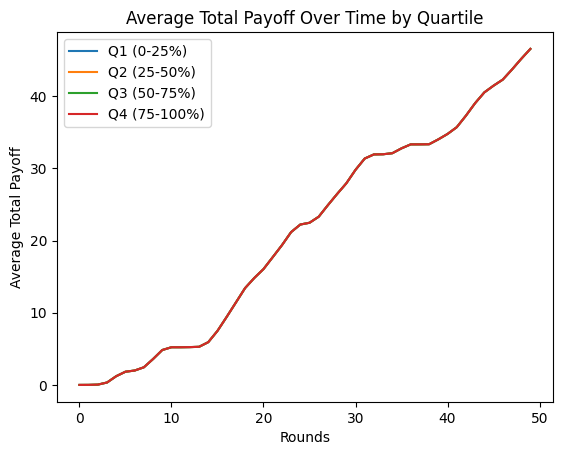

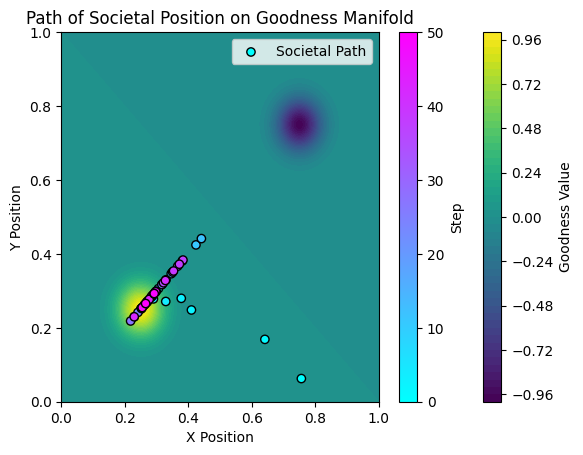

In [68]:
# Parameters for individual simulations
population_size = 100
num_officials = 10
rounds = 50

# Run individual simulation
sortition_gov = SortitionGovernment(population_size, num_officials, goodness_function)
payoffs_over_time, direction_maximizations_over_time, direction_minimizations_over_time, societal_path, goodness_values = sortition_gov.simulate(rounds)

# Plotting results by quartile
plot_quartiles(payoffs_over_time)

# Plotting societal path on the goodness manifold
plot_societal_path(societal_path, goodness_function)



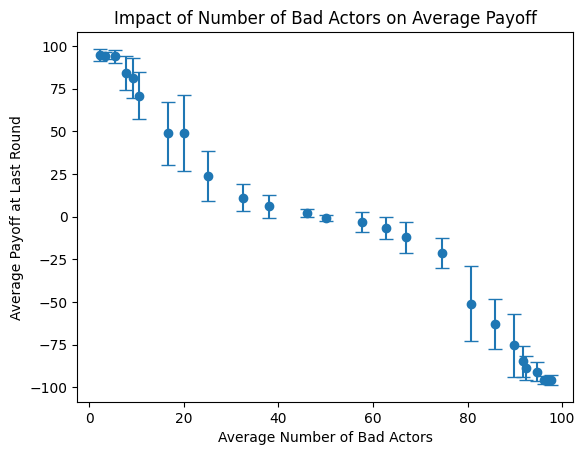

In [67]:
simulation = SortitionSimulation(population_size, num_officials, rounds, num_runs=10)
morality_means = np.linspace(-1, 1, 25)
simulation.plot_bad_actors_impact(morality_means)